In [1]:
from qiskit import QuantumCircuit, Aer, execute
from qiskit.quantum_info import Statevector, partial_trace
from qiskit.visualization import array_to_latex
import numpy as np

### Teleportacja kwantowa

W tym notatniku przedstawiony zostanie protokół teleportacji kwantowej. Jest to protokół, który umożliwia przeniesienie stanu kwantowego z jednego kubitu na inny. Należy podkreślić, że: 
- teleportacja kwantowa nie łamie kwantowego zakazu klonowania (ang. *no-cloning theorem*), ponieważ informacja kwantowa w tym protokole nie jest kopiowana, a jedynie przenoszona na inny kubit (zostaje zniszczona na początkowym kubicie),  
- w teleportacji kwantowej nie zachodzi przesłanie fizycznej materii; teleportowany jest jedynie stan kwantowy kubitu.

----

### Implementacja

Wyobraźmy sobie, że Alicja i Bob chcą przeprowadzić protokół teleportacji i przeteleportować stan $\vert\psi\rangle=\vert 1 \rangle$ od Alicji do Boba. Zakładamy, że Alicja i Bob mają do dyspozycji parę splątanych cząstek w stanie Bella, których mogą użyć, aby przeprowadzić teleportację.  


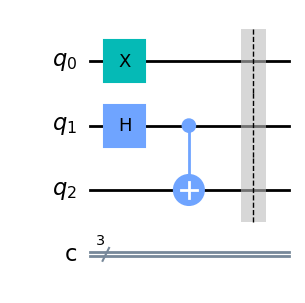

In [2]:
# Inicjalizujemy układ złożony z trzech kubitów:
# q0 - kubit Alicji w stanie |psi>, który chcemy przeteleportować
# q1 - drugi kubit Alicji, będzie to jeden z pary dwóch splątanych fotonów
# q2 - kubit Boba, zostani on splątany z kubitem q1, 
#     (cel teleportacji, docelowo po całym protokole ma się znaleźć w stanie |psi>) 

circuit = QuantumCircuit(3,3)

# Następnie przygotowujemy kubit Alicji w stanie, który chcemy przetelportować (|1>)
circuit.x(0)

# Tworzymy splątanie między cząstkami q1 oraz q2
circuit.h(1)
circuit.cx(1,2)

circuit.barrier()

# Tak wygląda układ przygotowany do przeprowadzenia teleportacji
circuit.draw(output="mpl")

Następnie Alicja wykonuje serię operacji na swoich kubitach, a potem wykonuje pomiar obu kubitów.

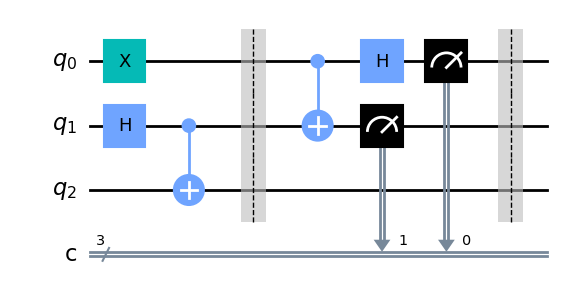

In [3]:
# Alicja działa bramką CNOT oraz bramką Hadamarda.
circuit.cx(0,1)
circuit.h(0)

# Następnie Alicja mierzy oba kubity i zapisuje wyniki w klasycznych bitach 0 oraz 1
circuit.measure([0, 1], [0, 1])

circuit.barrier()
circuit.draw(output="mpl")

Alicja przekazuje Bobowi wyniki pomiarów klasycznym kanałem komunikacji. Zależnie od otrzymanej informacji, Bob aplikuje odpowiednie bramki kwantowe na swoim kubicie, aby ostatecznie otrzymać w wyniku stan $\vert\psi\rangle$ .

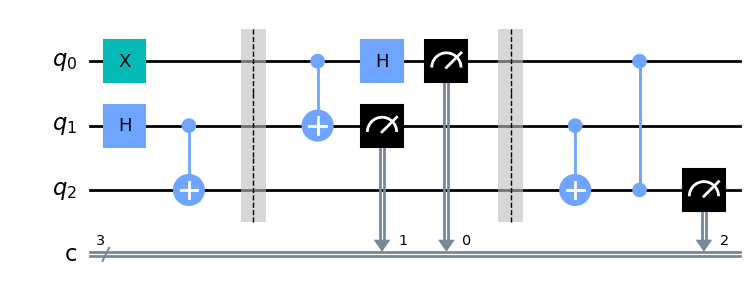

In [4]:
# Bob wykonuje odpowiednie operacje (odpowiednie bramki), znając wyniki pomiarów Alicji.

# Teoretycznie powinno być tak 
# (przesłanie wyników pomiarów klasycznie 
# i zastosowanie odpowiednich bramek 
# zależnie od wyników klasycznych bitów):
# circuit.measure([0, 1], [0, 1])
# circuit.x(2).c_if(cr2, 1)
# circuit.z(2).c_if(cr1, 1)

# Jednak na prawdziwym komputerze kwantowym nie ma na razie możliwości 
# wprowadzania bitów klasycznych.
# U Alicji kubity po pomiarze już przeszły w ustalony stan, 
# więc można wykorzystać operacje czysto kwantowe.
# Użycie bramek "controlled" pełni funkcję operacji IF
# IF bit1 == 1 -> bramka X w działaniu na kubit 2
# IF bit2 == 1 -> bramka Z w działaniu na kubit 2

circuit.cx(1, 2)
circuit.cz(0, 2)

# Ostatecznie mierzymy kubit Boba, aby sprawdzić czy teleportacja powiodła się.
circuit.measure([2], [2])

# Oto cały obwód służący do teleportacji
circuit.draw(output='mpl')

### Przeprowadzenie symulacji

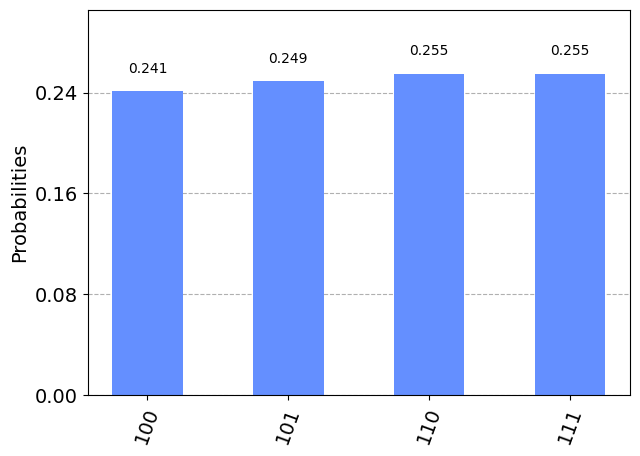

In [5]:
simulator = Aer.get_backend('qasm_simulator')
result = execute(circuit, backend=simulator, shots=1024).result()
from qiskit.visualization import plot_histogram
plot_histogram(result.get_counts(circuit))

Uwaga (przypomnienie) - kolejność kubitów w etykietkach jest od prawej do lewej - najmłodsze bity po prawej stronie. Jak widać, stan kubitu $2$ (pierwsza cyfra etykiety) jest zawsze równy 1, z racji że teleportowaliśmy stan $\vert1\rangle$ na kubit 2.

----
### Teleportacja ogólnego stanu (superpozycji |0> oraz |1>)

Zaczniemy od stworzenia ogólniejszego stanu $\vert \psi \rangle$, będącego superpozycją stanów bazowych $\vert 0 \rangle$ oraz $\vert 1 \rangle$. W tym celu wprowadzimy parametr $\theta$:  
$ \vert \psi \rangle = \text{cos}\cfrac{\theta}{2} \, \vert 0 \rangle + \text{sin}\cfrac{\theta}{2}\, \vert 1 \rangle $  
Aby przekształcić stan początkowy $\vert 0 \rangle$ w stan zależny od $\theta$, użyjemy bramki $R_Y$, czyli macierzy obrotu wokół osi Y (przy wizualizacji na sferze Blocha). W postaci macierzowej bramka ta wygląda nastepująco:  
$R_Y = \begin{bmatrix} \text{cos}\cfrac{\theta}{2} & - \text{sin}\cfrac{\theta}{2} \\  \text{sin}\cfrac{\theta}{2} &  \text{cos}\cfrac{\theta}{2} \end{bmatrix} $  
Uwaga - ta reprezentacja nie obejmuje wszystkich możliwych stanów. Aby objąć wszystkie możliwe stany, trzeba użyć przynajmniej dwóch rotacji (dwóch parametrów). Więcej informacji na ten temat w notatniku `05_sfera_blocha.ipynb`.

In [6]:
def create_state_psi(theta):
    
    # zwraca stan |psi> = cos(theta/2)*|0> + sin(theta/2)*|1>
    # theta = 0 => układ jest w stanie |0>
    # theta = pi => układ jest w stanie |1>
    
    psi_circuit = QuantumCircuit(1, name='create state to be teleported')
    psi_circuit.ry(theta, 0)
    
    return psi_circuit

Możemy wyświetlić przykładowe stany generowane przez $R_Y$, zależnie od wartości parametru $\theta$:

In [7]:
for iteration in range(-4, 5, 1):
    theta = iteration*(np.pi/4)
    psi_circuit = create_state_psi(theta)
    psi_circuit.draw(output="mpl")
    st0 = Statevector.from_instruction(psi_circuit)
    print(f"theta {theta:2.4f}, vector: {np.array2string(st0.data, precision=2, floatmode='fixed', suppress_small=True)}")

theta -3.1416, vector: [ 0.00+0.00j -1.00+0.00j]
theta -2.3562, vector: [ 0.38+0.00j -0.92+0.00j]
theta -1.5708, vector: [ 0.71+0.00j -0.71+0.00j]
theta -0.7854, vector: [ 0.92+0.00j -0.38+0.00j]
theta 0.0000, vector: [1.00+0.00j 0.00+0.00j]
theta 0.7854, vector: [0.92+0.00j 0.38+0.00j]
theta 1.5708, vector: [0.71+0.00j 0.71+0.00j]
theta 2.3562, vector: [0.38+0.00j 0.92+0.00j]
theta 3.1416, vector: [0.00+0.00j 1.00+0.00j]


Naszym celem jest określenie czy stan kubitu 0 przed teleportacją jest taki sam jak stan kubitu 2 po teleportacji. W tym celu potrzebna nam będzie możliwość określenia stanu jednego z kilku kubitów w układzie. Obiekt `Statevector` umożliwia wyświetlenie stanu całego układu trzech kubitów łącznie (tj. wektor w przestrzeni $H_0 \otimes H_1 \otimes H_2$), natomiast my potrzebujemy z tego wyodrębnić wektor dla kubitu 0 lub 2.   

W tym celu posłużymy się operacją *śladu częściowego (ang. partial trace)*. 

In [8]:
def single_qubit_state(circuit, qubits_to_trace_out):
    
    # określenie wektora stanu całego układu (łącznego wektora stanu kilku kubitów)
    full_statevector = Statevector.from_instruction(circuit)

    # wykonanie operacji śladu częściowego - 
    # określamy, których kubitów chcemy się "pozbyć" z układu
    partial_density_matrix = partial_trace(full_statevector, qubits_to_trace_out)

    # jako wynik dostaliśmy macierz gęstości, 
    # z racji, że mamy stan czysty to możemy z macierzy gęstości 
    # wydobyć informację o wektorze stanu
    partial_statevector = np.sqrt(np.diagonal(partial_density_matrix))

    return partial_statevector

Teraz już możemy zdefiniować funkcję, która zbuduje obwód, przy pomocy którego przeprowadzimy teleportację, a także zapiszemy stan układu przed i po protokole teleportacji.

In [9]:
def circuit_with_state_extraction(theta):

    circuit = QuantumCircuit(3, 3)
    
    # ustalenie kubitu 0 w stanie, który chcemy teleportować
    circuit.append(create_state_psi(theta).to_instruction(), [0])
    
    # zapisanie stanu początkowego kubitu 0 
    # (do porównania z wynikiem na kubicie 2)
    state_to_teleport = single_qubit_state(circuit, [1,2])
    
    # splątanie kubitów 1 i 2 - stworzenie pary Bella, 
    # z której jeden kubit ma Alicja, a drugi ma Bob
    circuit.h(1)
    circuit.cx(1,2)

    # wykonanie odpowiednich operacji przez Alicję
    circuit.cx(0,1)
    circuit.h(0)
    
    # wykonanie odpowiednich operacji przez Boba -
    # zaaplikowanie bramek zależnie od wyników pomiarów u Alicji
    circuit.cx(1,2)
    circuit.cz(0,2)

    # zapisanie stanu wynikowego kubitu 2 (do sprawdzenia czy teleportacja zakończona sukcesem)
    state_after_teleportation = single_qubit_state(circuit, [0,1])
    
    return state_to_teleport, state_after_teleportation


Teraz możemy sprawdzić stan przed i po teleportacji dla dowolnego parametru wejściowego $\theta$. Powinny być zawsze jednakowe, dla dowolnego kąta $\theta$.

In [10]:
theta = np.pi/3

state_to_teleport, state_after_teleportation = circuit_with_state_extraction(theta)

print(f"Stan przed teleportacją: {state_to_teleport}") 
print(f"Stan po teleportacji   : {state_after_teleportation}")

Stan przed teleportacją: [0.8660254+0.j 0.5      +0.j]
Stan po teleportacji   : [0.8660254+0.j 0.5      +0.j]


### Wersja Qiskit

In [11]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.21.2', 'qiskit-aer': '0.11.0', 'qiskit-ignis': None, 'qiskit-ibmq-provider': '0.19.2', 'qiskit': '0.38.0', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}